In [21]:
# following the documentation of reservoirpy @ 
# https://reservoirpy.readthedocs.io/en/latest/user_guide/getting_started.html
import reservoirpy as rpy

rpy.verbosity(0) # reduce messages and warnings
rpy.set_seed(42)



In [22]:
from reservoirpy.nodes import Reservoir

reservoir = Reservoir(100, lr=0.5, sr = 0.9)

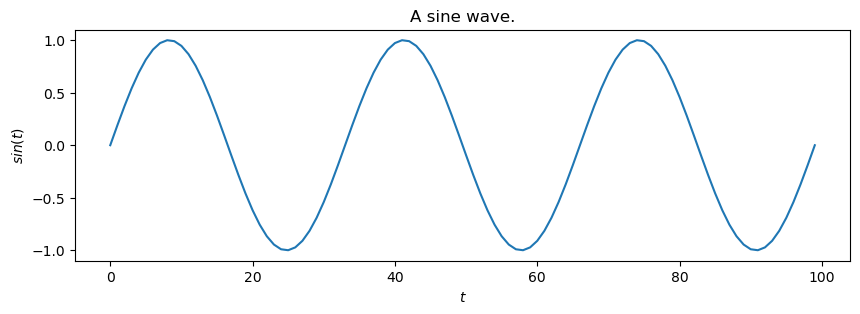

In [23]:
# a dataset 
import numpy as np
import matplotlib.pyplot as plt

X = np.sin(np.linspace(0, 6*np.pi, 100)).reshape(-1, 1)

plt.figure(figsize=(10, 3))
plt.title("A sine wave.")
plt.ylabel("$sin(t)$")
plt.xlabel("$t$")
plt.plot(X)
plt.show()

In [24]:
s = reservoir(X[0].reshape(1, -1))

In [25]:
states = np.empty((len(X), reservoir.output_dim))
for i in range(len(X)):
    states[i] = reservoir(X[i].reshape(1, -1))

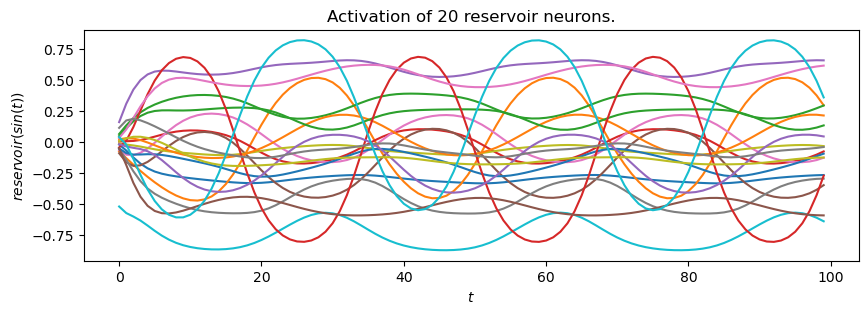

In [26]:
plt.figure(figsize=(10, 3))
plt.title("Activation of 20 reservoir neurons.")
plt.ylabel("$reservoir(sin(t))$")
plt.xlabel("$t$")
plt.plot(states[:, :20])
plt.show()

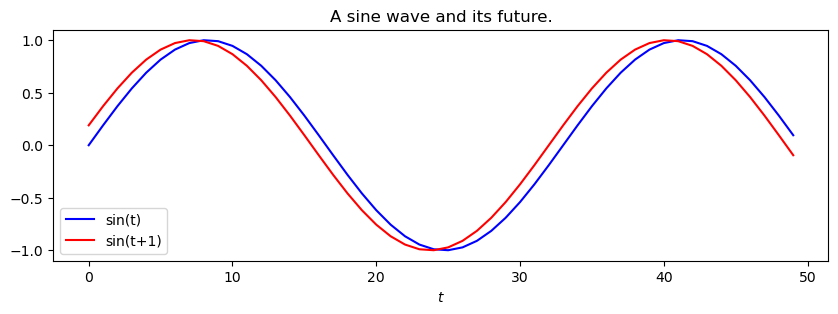

In [27]:
# some tasks
X_train = X[:50]
Y_train = X[1:51]


plt.figure(figsize=(10, 3))
plt.title("A sine wave and its future.")
plt.xlabel("$t$")
plt.plot(X_train, label="sin(t)", color="blue")
plt.plot(Y_train, label="sin(t+1)", color="red")
plt.legend()
plt.show()

In [28]:
train_states = reservoir.run(X_train, reset=True)

In [29]:
from reservoirpy.nodes import Ridge

readout = Ridge(ridge=1e-7)
readout = readout.fit(train_states, Y_train, warmup=10)

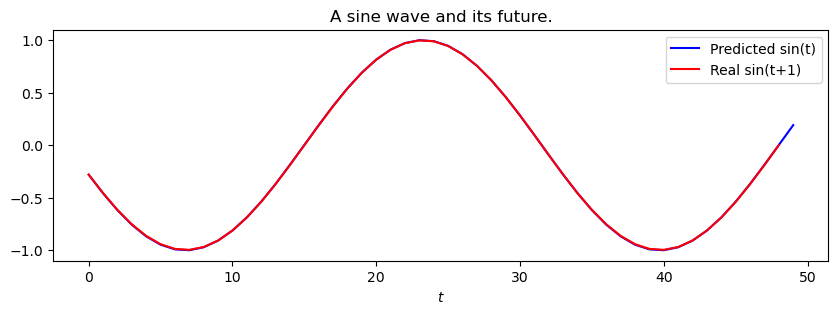

In [30]:
test_states = reservoir.run(X[50:])
Y_pred = readout.run(test_states)

plt.figure(figsize=(10, 3))
plt.title("A sine wave and its future.")
plt.xlabel("$t$")
plt.plot(Y_pred, label="Predicted sin(t)", color="blue")
plt.plot(X[51:], label="Real sin(t+1)", color="red")
plt.legend()
plt.show()

In [31]:
# models can be built using >>
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(100, lr=0.5, sr=0.9)
ridge = Ridge(ridge=1e-7)

esn_model = reservoir >> ridge
esn_model = esn_model.fit(X_train, Y_train, warmup=10)

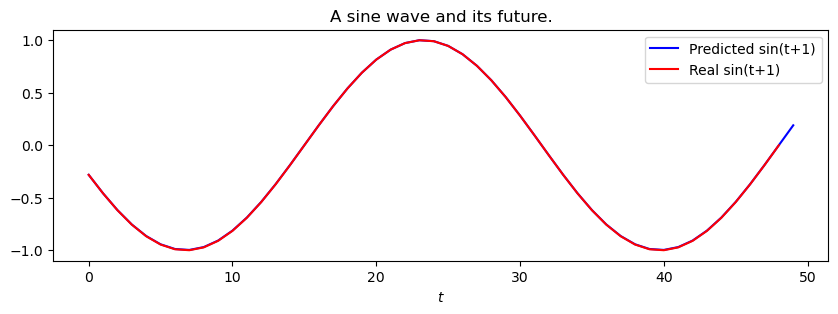

In [32]:
Y_pred = esn_model.run(X[50:])

plt.figure(figsize=(10, 3))
plt.title("A sine wave and its future.")
plt.xlabel("$t$")
plt.plot(Y_pred, label="Predicted sin(t+1)", color="blue")
plt.plot(X[51:], label="Real sin(t+1)", color="red")
plt.legend()
plt.show()

In [33]:
# trying it on Mackey-Glass timeseries
from reservoirpy.nodes import Ridge, Reservoir
from reservoirpy.datasets import mackey_glass
from reservoirpy import set_seed

set_seed(42)

# import matplotlib.pyplot as plt


In [34]:
X = mackey_glass(2500)
X_train = X[:2000]
y_train = X[1:2001]
X_test = X[2000:-1]
y_test = X[2001:]

In [35]:
res = Reservoir(100, sr=0.8, lr=0.5)

readout = Ridge(ridge = 1e-6)

esn = res >> readout

In [36]:
predictions = esn.fit(X_train, y_train).run(X_test)

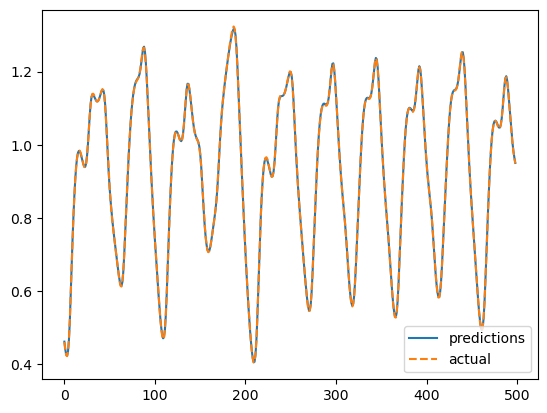

In [37]:
plt.plot(predictions, label='predictions')
plt.plot(y_test, label='actual', linestyle='--')
plt.legend()
plt.show()

In [1]:
from generate_flip_flop import *
from matplotlib import pyplot as plt
import random
the_answer_to_the_universe = 42
# from extracting import *
from reservoirpy.nodes import Reservoir, FORCE, Ridge

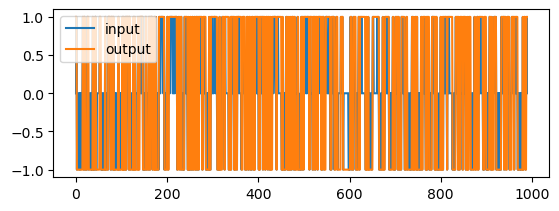

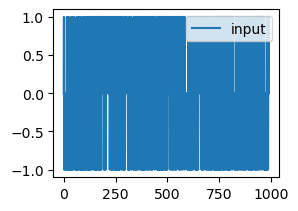

In [12]:
# try with flip-flops
random.seed(the_answer_to_the_universe)
N = 70_000
random_state = the_answer_to_the_universe
n = 1
q = 0.01
x, y, y_label = sequence(N, q, n, random_state) 
# n_train = ceil(0.8*N)
n_train = 50_000
x_train = x[:n_train]
y_train_label = y_label[:n_train]
y_train = y[:n_train]
lag = 0
n_test = N - n_train + lag
x_test = x[n_train-lag:]
y_test_label = y_label[n_train-lag:]
y_test = y[n_train-lag:]
#%%
# plot = False
plot = True
n_start = 10
n_end = 1000
d = 0
if plot:
    plt.subplot(2, 1, 1)
    plt.plot(x_train[n_start:n_end, d])
    plt.plot(y_train[n_start:n_end, d])
    plt.legend(['input', 'output'])
    plt.show()
    plt.subplot(2, 2, 1)
    plt.plot(x_train[n_start:n_end, d])
    plt.legend(['input', 'output'])
    plt.show()

In [3]:

from reservoirpy.nodes import Ridge, Reservoir, FORCE

In [4]:

# random.seed(the_answer_to_the_universe)
n_neurons = 100
reservoir = Reservoir(n_neurons, sr=0.9, rc_connectivity=0.05, lr = 1, 
        input_bias=False)
readout = Ridge(ridge=1e-4, input_bias=False)
# This force learning uses a single layer online neural network. 
# readout = FORCE(alpha=1e-6)


reservoir <<= readout  ## feedback

esn = reservoir >> readout 
esn = esn.fit(x_train, y_train)
# _ = esn.train(x_train, y_train, force_teachers=True,
        # learn_every = 5) # this prevents the printing of the output below

Running Model-0:   0%|          | 0/1 [00:00<?, ?it/s]

Running Model-0: 50000it [00:09, 5306.26it/s]
Running Model-0: 100%|██████████| 1/1 [00:09<00:00,  9.44s/it]

Fitting node Ridge-0...


In [5]:
esn.params['Reservoir-0']['Win'].shape

(100, 1)

In [99]:
class ESN:
    def __init__(self, Wr, Win, Wout, x_init, Wfb=None):
        self.Wr = Wr
        self.Win = Win
        self.Wout = Wout
        self.Wfb = Wfb
        self.x_init = x_init
    def forward(self, X):
        ''' 
        X is the input and it should of the shape (sequence length, n_features)
        '''

        seq_len = X.shape[0]
        n_out = self.Wout.shape[1]
        y_fdb = np.zeros((seq_len+1, n_out)) 
        x_out = np.zeros((seq_len+1, self.Wr.shape[0]))
        x_out[0] = self.x_init
        fdb = True
        if self.Wfb is None:
            Wfb = np.zeros(self.Wr.shape[0], n_out)
            fbd = False
        x_t = self.x_init
        for t in range(1, seq_len+1):
            u_t = X[t-1] @ Win.T
            x_t =  x_out[t-1] @ self.Wr.T 
            fb_t = self.Wfb @ y_fdb[t-1] 
            x_out[t] = np.tanh(u_t + x_t + fb_t)
            y_fdb[t] = x_out[t] @ self.Wout
        return x_out[1:], y_fdb[1:]

In [101]:
res = esn.params['Reservoir-0']
read = esn.params['Ridge-0']
Win, Wout, Wr, Wfb, x_init = res['Win'], read['Wout'], res['W'], res['Wfb'], res['internal_state']

extract = ESN(Wr, Win, Wout, x_init, Wfb)

y_out = extract.forward(x_train[:10])
# (Wfb @ y_train[0]).shape

In [6]:
preds = esn.run(x_train)

Running Model-0: 50000it [00:08, 5683.58it/s]         


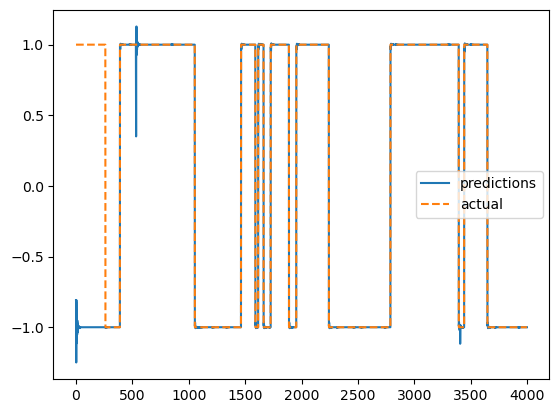

In [7]:
n_start = 0
n_steps = 4000
d = 0
plt.plot(preds[n_start:(n_start + n_steps), d], label='predictions')
plt.plot(y_train[n_start:(n_start + n_steps), d], label='actual', linestyle='--')
# plt.plot(x_train[n_start:(n_start + n_steps), d], label = 'input', linestyle='-.')
plt.legend()
plt.show()

In [8]:
preds_test = esn.run(x_test)

Running Model-0: 20000it [00:04, 4967.61it/s]         


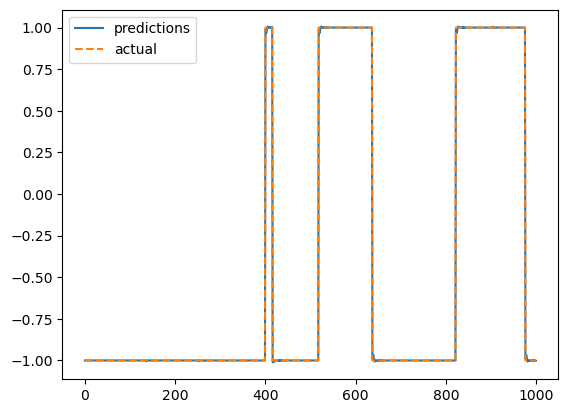

In [9]:
n_start = 10000
# n_steps = x_test.shape[0]
n_steps = 1000
d = 0
plt.plot(preds_test[n_start:(n_start + n_steps), d], label='predictions')
plt.plot(y_test[n_start:(n_start + n_steps), d], label='actual', linestyle='--')
# plt.plot(x_train[n_start:(n_start + n_steps), d], label = 'input', linestyle='-.')
plt.legend()
plt.show()

In [17]:
N_new = 10000
x_new, y_new, _ = sequence(N_new, 0.02, n, 1)

In [18]:
pred_new_data = esn.run(x_new)

Running Model-0: 10000it [00:02, 4505.18it/s]         


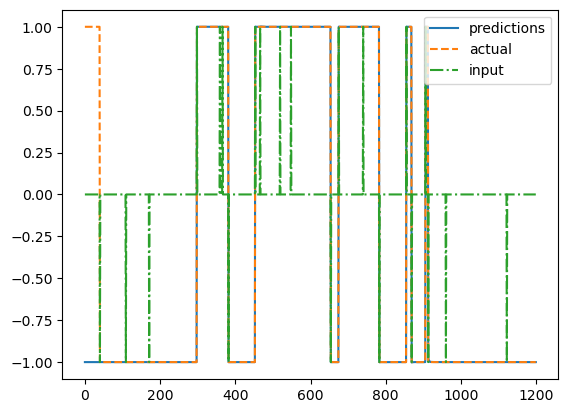

In [19]:
n_start = 0
# n_steps = x_test.shape[0]
n_steps = 1200
d = 0
plt.plot(pred_new_data[n_start:(n_start + n_steps), d], label='predictions')
plt.plot(y_new[n_start:(n_start + n_steps), d], label='actual', linestyle='--')
plt.plot(x_new[n_start:(n_start + n_steps), d], label='input', linestyle='-.')
# plt.plot(x_train[n_start:(n_start + n_steps), d], label = 'input', linestyle='-.')
plt.legend()
plt.show()

In [134]:
train_test_data = (x_train, y_train)
with open('train_test.pkl', 'wb') as f:
    pickle.dump(train_test_data, f)

In [123]:
import pickle

params = esn.params

with open('params.pkl', 'wb') as g:
    pickle.dump(params, g)

(70000, 1)


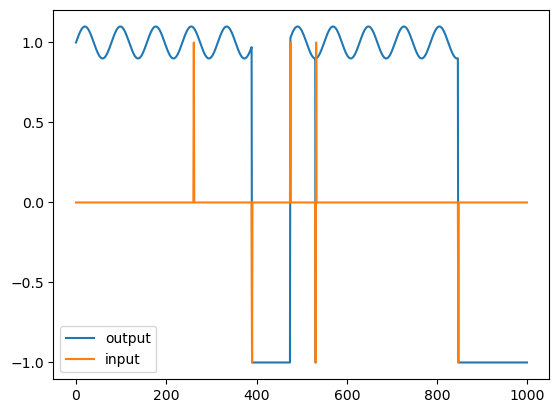

In [170]:
f_1, f_2, a_1, a_2 = 0.08, 0.101, 0.2, 0.5
y_1 = a_1*np.sin(f_1*np.linspace(0, N, N))/2 + 1
y_2 = a_2*np.sin(f_2*np.linspace(0, N, N))/2 - 1
y_periodic = np.zeros_like(y)
x_periodic = np.zeros((y.shape[0], 2))
print(y_periodic.shape)
for i in range(y.shape[0]):
    if y[i] == 1:
        y_periodic[i] = y_1[i]
    elif y[i] == -1:
        y_periodic[i] = -1
    #     y_periodic[i] = y_2[i]

n_train = 50_000
y_train_p = y_periodic[:n_train]
# y_1_train = y_1[:n_train].reshape(-1, 1)
# x = np.c_[x, y_1.reshape(-1, 1)]
x_periodic[:, 0] = x.flatten()
x_periodic[:, 1] = y_periodic.flatten()
x_train_p = x_periodic[:n_train]
lag = 0
n_test = N - n_train + lag
y_test_p = y_periodic[n_train-lag:]
plt.plot(y_train_p[0:1000], label='output')
plt.plot(x_train_p[0:1000, 0], label='input')
plt.legend()
plt.show()


In [171]:
n_neurons = 400
reservoir_1 = Reservoir(n_neurons, sr=0.9, rc_connectivity=0.05, lr = 0.5)
# readout_p = Ridge(ridge=1e-5)
# This force learning uses a single layer online neural network. 
readout_1 = FORCE(alpha=1e-4)


reservoir_1 <<= readout_1  ## feedback

esn_1 = reservoir_1 >> readout_1
# esn_p = esn_p.fit(x_train_p, y_train_p)
n_iter = 1
t_steps = 1
for i in range(n_iter):
        _ = esn_1.train(x_train_p, y_train_p, force_teachers=True,
                learn_every = t_steps) # this prevents the printing of the output below
        t_steps += 20

In [133]:
x_train_p.shape

(50000, 2)

In [172]:
x_p = x_train_p
# y1_pred = esn_1.run(x_train_p)
# x_p[:, 0]
y1_pred = esn_1.run(x_p)

Running Model-17: 50000it [00:14, 3514.11it/s]         


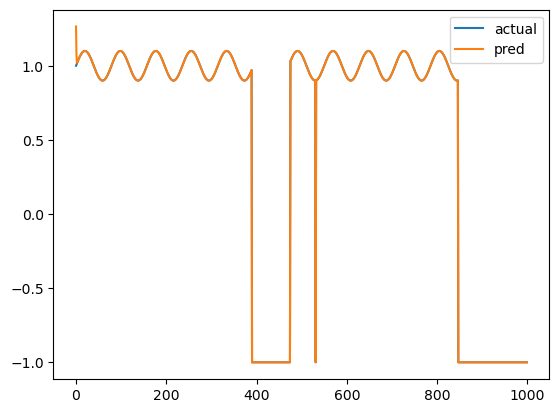

In [173]:
plt.plot(y_train_p[0:1000], label='actual')
plt.plot(y1_pred[0:1000], label = 'pred')
plt.legend()
plt.show()

(70000, 1)


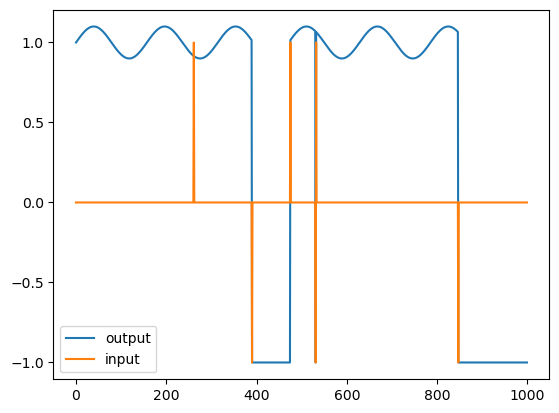

In [174]:

f_1, f_2, a_1, a_2 = 0.04, 0.101, 0.2, 0.5
y_1 = a_1*np.sin(f_1*np.linspace(0, N, N))/2 + 1
y_2 = a_2*np.sin(f_2*np.linspace(0, N, N))/2 - 1
y_periodic = np.zeros_like(y)
x_periodic = np.zeros((y.shape[0], 2))
print(y_periodic.shape)
for i in range(y.shape[0]):
    if y[i] == 1:
        y_periodic[i] = y_1[i]
    elif y[i] == -1:
        y_periodic[i] = -1
    #     y_periodic[i] = y_2[i]

n_train = 50_000
y_train_p = y_periodic[:n_train]
# y_1_train = y_1[:n_train].reshape(-1, 1)
# x = np.c_[x, y_1.reshape(-1, 1)]
x_periodic[:, 0] = x.flatten()
x_periodic[:, 1] = y_periodic.flatten()
x_train_p = x_periodic[:n_train]
lag = 0
n_test = N - n_train + lag
y_test_p = y_periodic[n_train-lag:]
plt.plot(y_train_p[0:1000], label='output')
plt.plot(x_train_p[0:1000, 0], label='input')
plt.legend()
plt.show()




In [177]:
y1_pred = esn_1.run(x_train_p)

Running Model-17: 50000it [00:12, 4119.58it/s]         


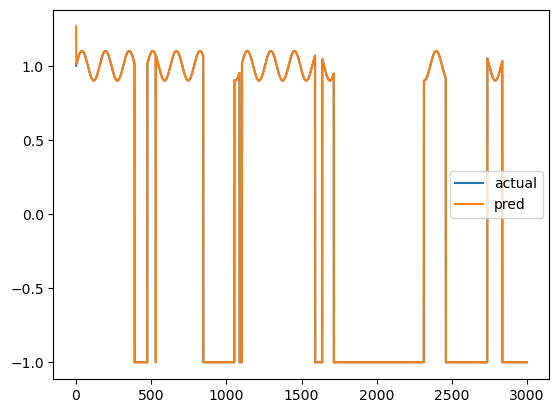

In [179]:
plt.plot(y_train_p[0:3000], label='actual')
plt.plot(y1_pred[0:3000], label = 'pred')
plt.legend()
plt.show()

In [12]:
esn.params['Ridge-0'].keys()

dict_keys(['Wout', 'bias'])